In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from matplotlib import pyplot as plt
%pylab inline

/Library/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
wages_raw = pd.read_csv('./WAG_C_M.csv', sep=';', parse_dates=['month'], index_col=['month'], dayfirst=True)
wages_raw.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


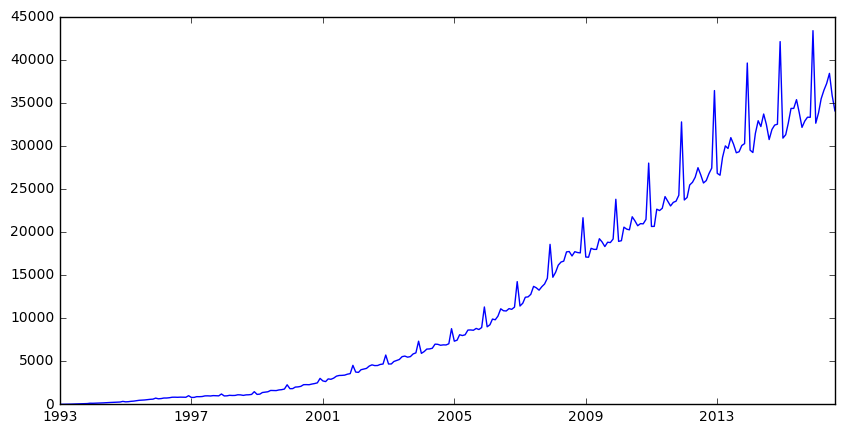

In [3]:
plt.figure(figsize={5,10})
plt.plot(wages_raw.WAG_C_M)

In [4]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Критерий Дики-Фуллера: p=0.991850


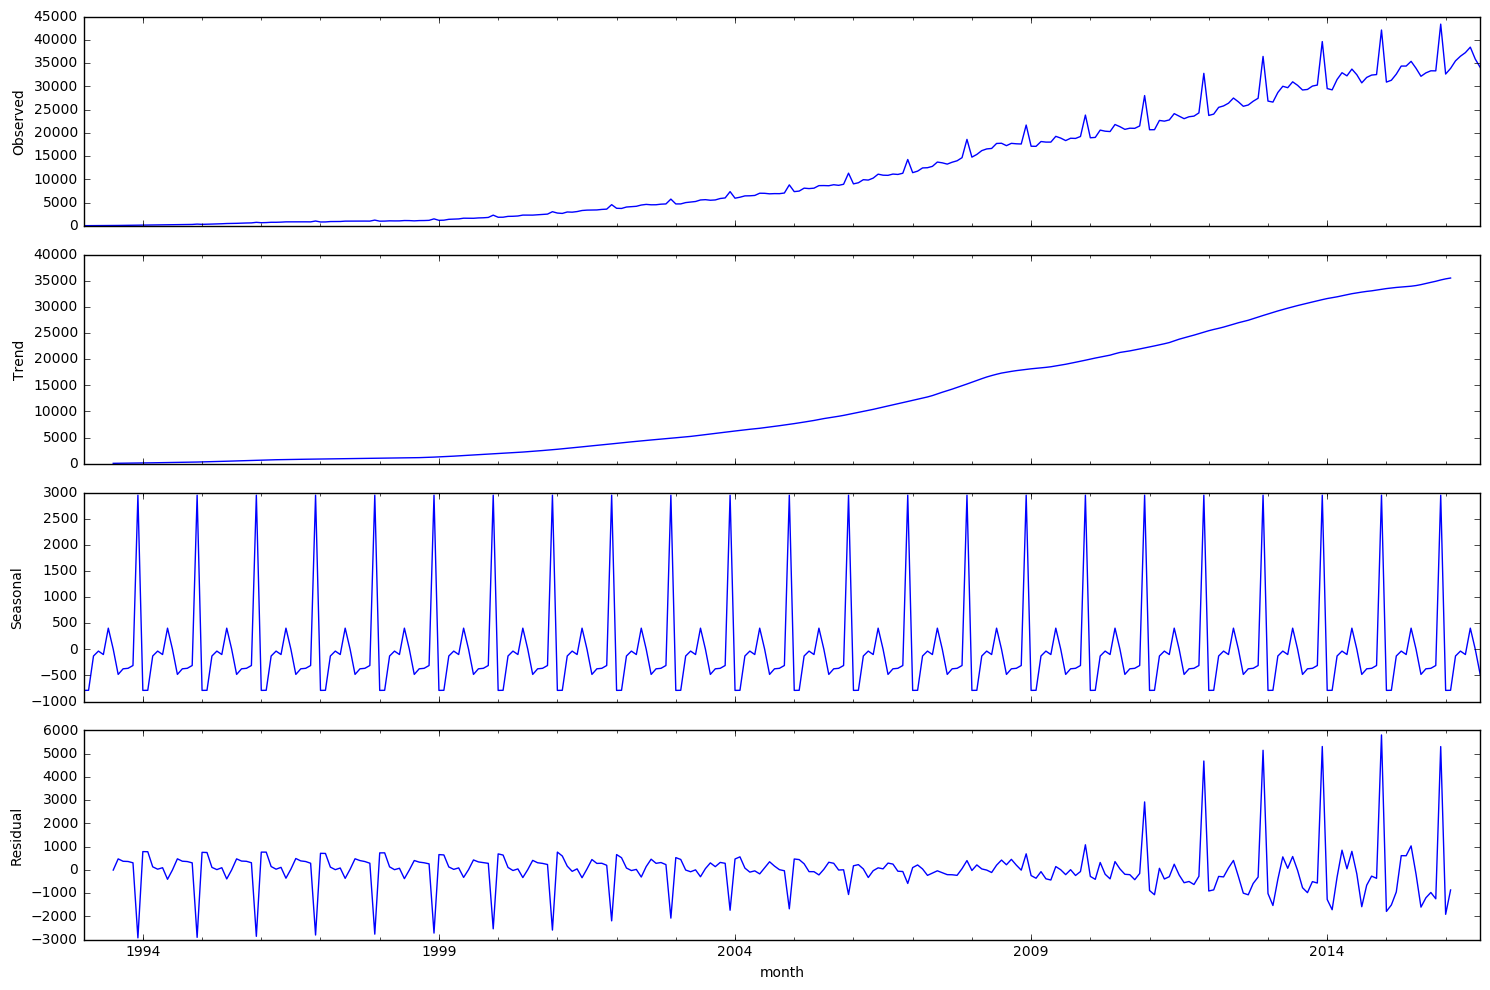

In [5]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wages_raw.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wages_raw.WAG_C_M)[1])

Видно невооруженным глазом, что ряд нестационарен; попытаемся применить преобразование Бокса-Кокса.

In [6]:
wages_raw['WAG_C_M_cox'], lmbd = stats.boxcox(wages_raw.WAG_C_M)

Критерий Дики-Фуллера: p=0.696899,
lambda=0.263202


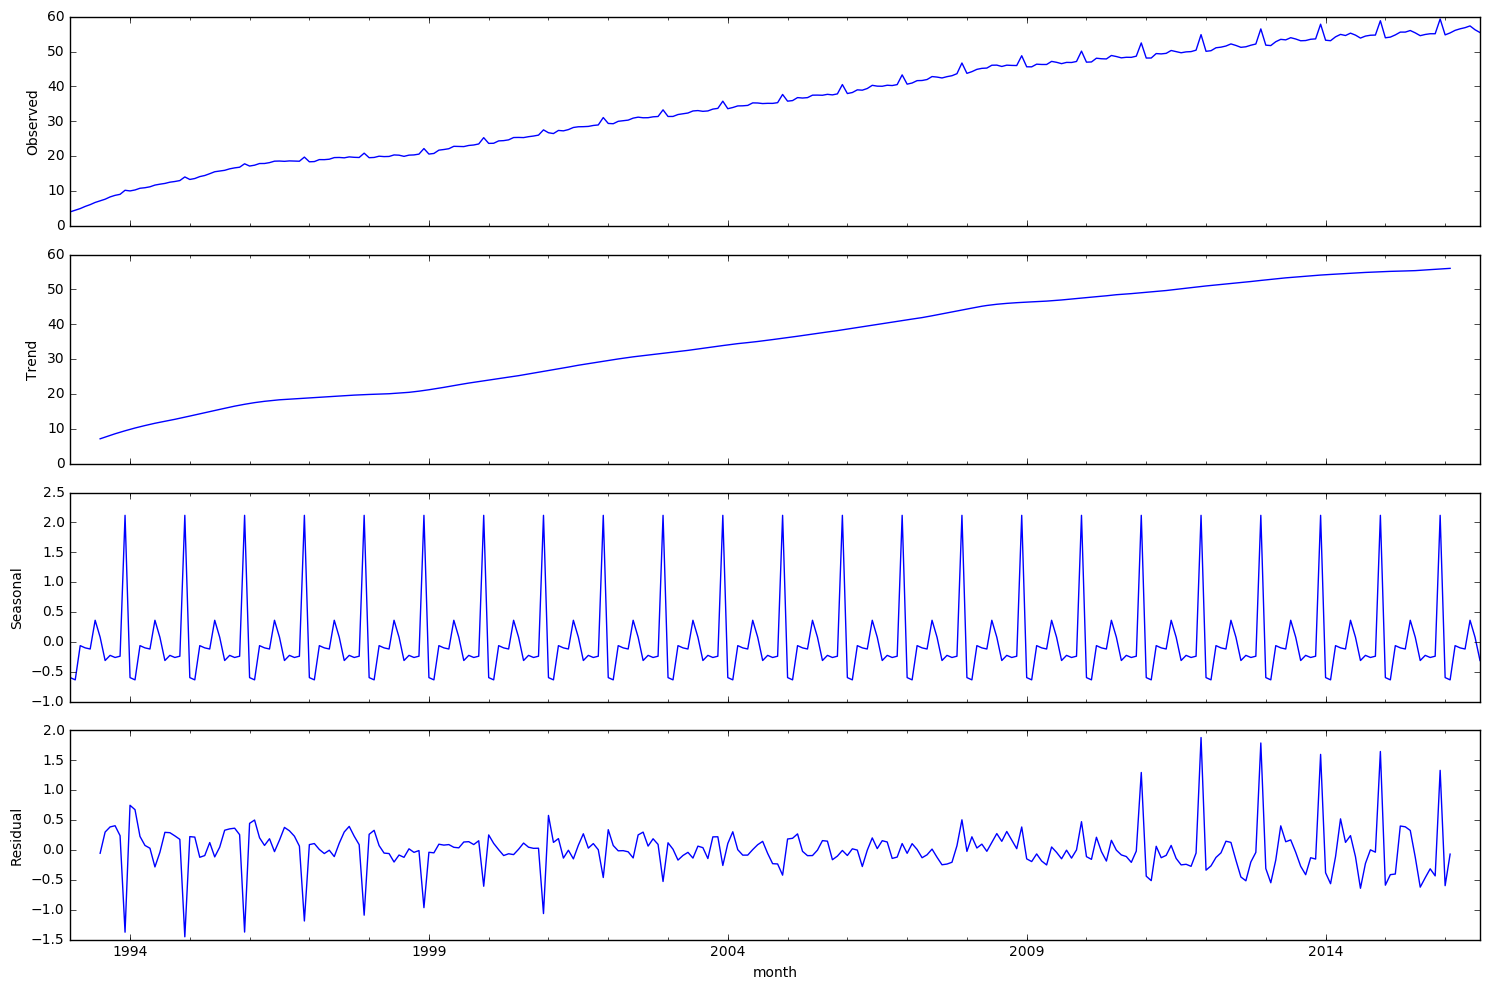

In [7]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wages_raw.WAG_C_M_cox).plot()
print("Критерий Дики-Фуллера: p=%f,\nlambda=%f" % (sm.tsa.stattools.adfuller(wages_raw.WAG_C_M_cox)[1], lmbd))

После преобразования Бокса-Кокса гипотеза нестационарности не отвергается; ярко выражен тренд, вычтем его с помощью дифференцирования.

In [8]:
wages_raw['WAG_C_M_cox_diff'] = wages_raw['WAG_C_M_cox'][1:] - wages_raw['WAG_C_M_cox'].shift(1)
wages_raw['WAG_C_M_cox_diffs'] = wages_raw['WAG_C_M_cox_diff'][1:] - wages_raw['WAG_C_M_cox_diff'][1:].shift(12)

Критерий Дики-Фуллера: p=0.000000,
lambda=0.263202


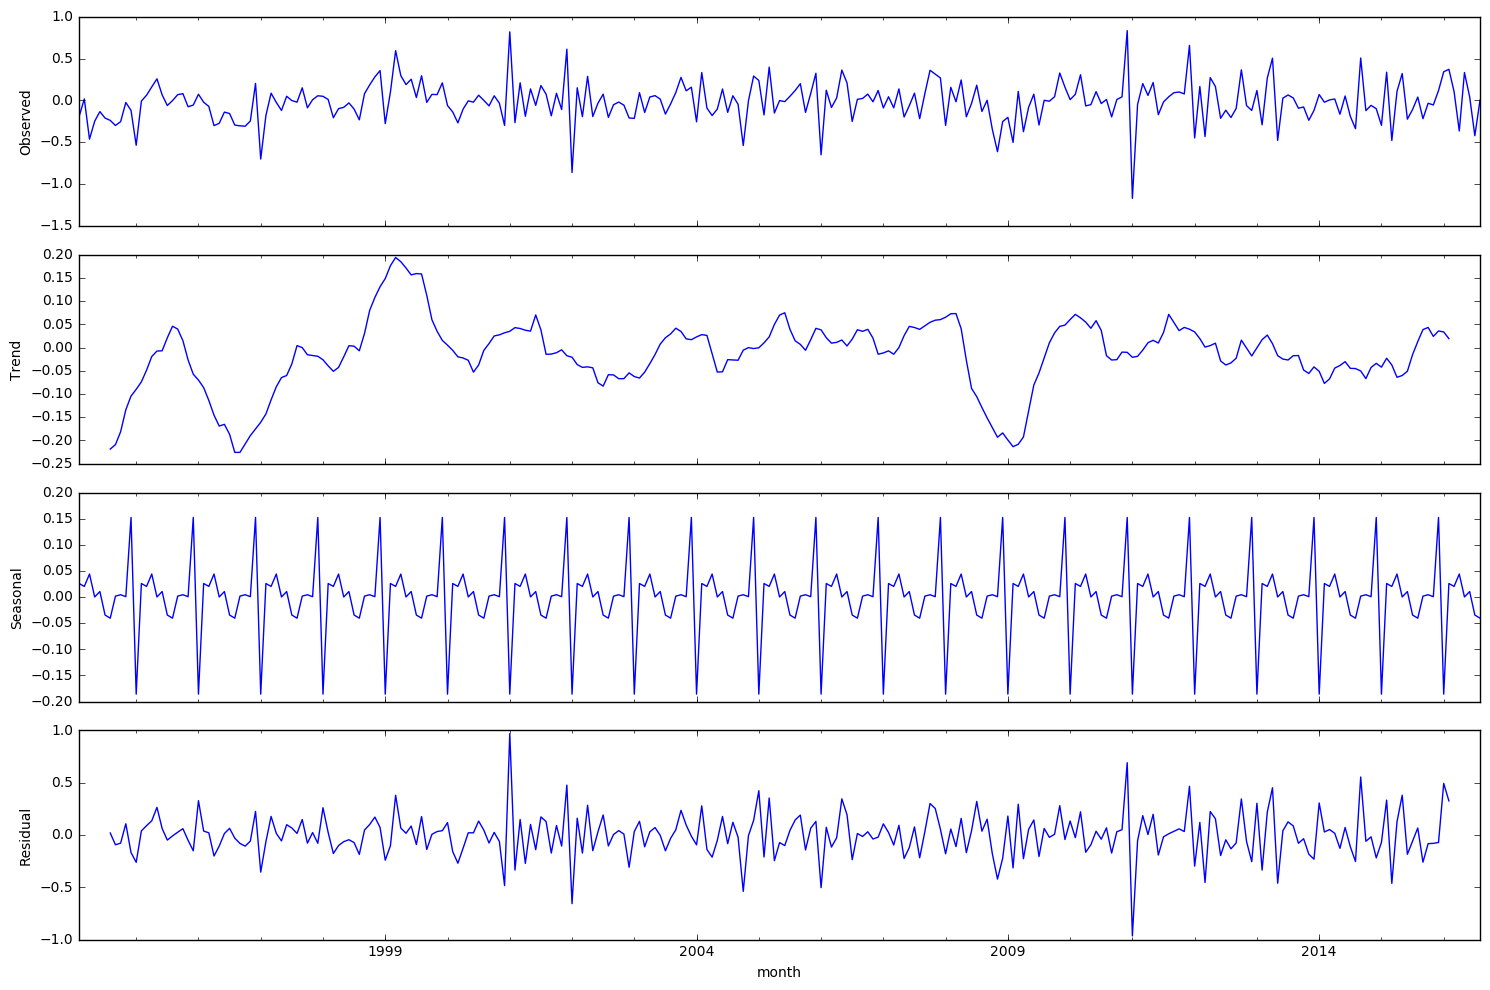

In [9]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wages_raw.WAG_C_M_cox_diffs[13:]).plot()
print("Критерий Дики-Фуллера: p=%f,\nlambda=%f" % (sm.tsa.stattools.adfuller(wages_raw.WAG_C_M_cox_diffs[13:])[1], lmbd))

### Успех
Одного обычного и одного сезонного дифференцирования оказалось достаточно, чтобы сделать ряд значимо стационарным.  
Данные лежат в поле WAG_C_M_cox_diffs.

### p, P, q, Q 

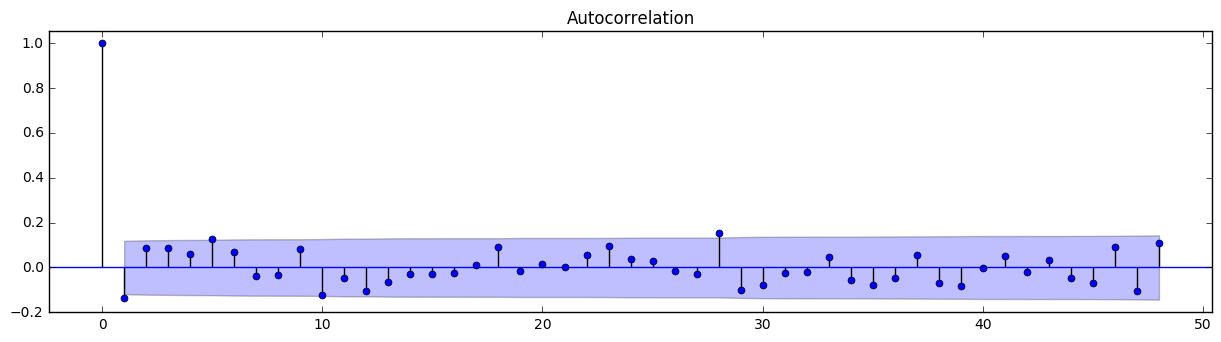

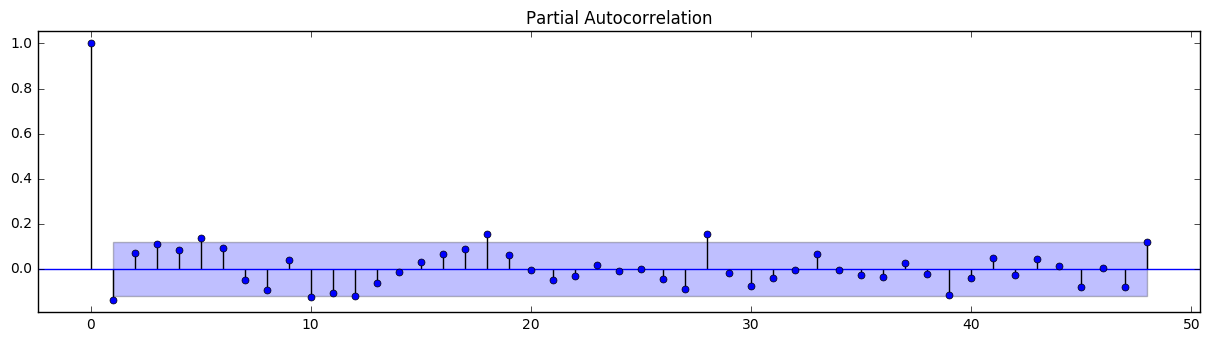

In [10]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wages_raw.WAG_C_M_cox_diffs[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wages_raw.WAG_C_M_cox_diffs[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Согласно эвристикам выбираем:  
$Q = 0$  
$q = 1$, может быть при $q=10$ коррелированность тоже значима  
$P = 1$  
$p = 1$,  
но все же проверим модели более высокого порядка.

In [13]:
from itertools import product
ps = range(0, 6)
d = 1
qs = range(0, 6)
Ps = range(0, 2)
D = 1
Q = 0

pPq = product(ps,Ps,qs)

In [14]:
import warnings
warnings.filterwarnings('ignore')
results = []
best_aic = float("inf")

for param in pPq:
    try:
        model=sm.tsa.statespace.SARIMAX(wages_raw.WAG_C_M_cox, order=(param[0], d, param[2]), 
                                        seasonal_order=(param[1], D, Q, 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

('wrong parameters:', (0, 0, 0))
('wrong parameters:', (1, 0, 2))
('wrong parameters:', (1, 1, 2))
('wrong parameters:', (2, 0, 1))
('wrong parameters:', (2, 0, 2))
('wrong parameters:', (2, 1, 1))
('wrong parameters:', (2, 1, 2))
('wrong parameters:', (3, 0, 2))
('wrong parameters:', (3, 1, 2))
('wrong parameters:', (4, 0, 2))
('wrong parameters:', (4, 0, 4))
('wrong parameters:', (4, 1, 2))
('wrong parameters:', (4, 1, 4))
('wrong parameters:', (5, 0, 2))
('wrong parameters:', (5, 0, 3))
('wrong parameters:', (5, 0, 4))
('wrong parameters:', (5, 1, 2))
('wrong parameters:', (5, 1, 3))
('wrong parameters:', (5, 1, 4))


In [15]:
results.sort(lambda a,b: 1 if a[1]>b[1] else -1)
results

[[(5, 1, 5), -26.001595073729135],
 [(5, 0, 5), -22.829628932993927],
 [(4, 1, 3), nan],
 [(4, 0, 3), nan],
 [(3, 1, 4), nan],
 [(3, 1, 3), nan],
 [(3, 0, 5), -15.185913267435524],
 [(3, 1, 5), -15.108732420613642],
 [(3, 0, 4), nan],
 [(3, 0, 3), nan],
 [(2, 1, 5), -13.868575493854582],
 [(2, 1, 3), nan],
 [(2, 0, 3), nan],
 [(1, 1, 5), -15.867140189385388],
 [(1, 0, 5), -13.661215945848411],
 [(4, 0, 5), -13.579629267338333],
 [(4, 1, 5), -13.304223566821804],
 [(2, 0, 5), -11.955813698636138],
 [(1, 1, 4), -10.969007040960463],
 [(1, 1, 3), -10.548127456010548],
 [(0, 1, 5), -9.8031729805537324],
 [(2, 1, 4), -9.1696610380799406],
 [(1, 0, 4), -6.3380406872447423],
 [(0, 0, 5), -5.3766352750157402],
 [(1, 0, 3), -5.3617769287552477],
 [(5, 1, 1), -5.2601331408084206],
 [(3, 1, 1), -4.9958595481046224],
 [(2, 0, 4), -4.5715531336316104],
 [(5, 1, 0), -4.5459339356992032],
 [(4, 1, 1), -3.9759740151457024],
 [(5, 0, 0), -2.1049609241761651],
 [(0, 1, 4), -1.4608711065720108],
 [(3, 0,

### Лучшая модель
Лучшей оказалась модель с $\{p,P,q,Q,d,D\} = \{5,1,5,0,1,1\}$  
Значение метрики Акаике для этой модели: -26.001   
Достигаемые уровни значимости в тесте Льюнга-Бокса для разных лагов:

In [16]:
best_model.test_serial_correlation(method='ljungbox', lags = 48)[0,1]

array([ 0.99086239,  0.99421089,  0.99193763,  0.99104159,  0.99793741,
        0.99798444,  0.9993987 ,  0.99959095,  0.99551398,  0.9973998 ,
        0.99851433,  0.99940905,  0.99951846,  0.99980814,  0.99872546,
        0.99925559,  0.99886381,  0.99845298,  0.99879835,  0.99937447,
        0.99968045,  0.99981707,  0.99562023,  0.99598534,  0.99755449,
        0.99848638,  0.99878499,  0.99095299,  0.98559219,  0.97456144,
        0.97333286,  0.98081795,  0.97825289,  0.98005744,  0.96739536,
        0.97566994,  0.97327695,  0.97195467,  0.95923813,  0.96629445,
        0.95429225,  0.96395468,  0.97065345,  0.96732928,  0.92069677,
        0.92807512,  0.85591143,  0.8198883 ])

Судя по тестам ЛБ, гипотеза автокоррелированности не принимается ни на одном лаге

In [17]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                        WAG_C_M_cox   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  25.001
Date:                            Fri, 30 Dec 2016   AIC                            -26.002
Time:                                    02:31:57   BIC                             17.786
Sample:                                01-01-1993   HQIC                            -8.446
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0427     16.387      0.003      0.998     -32.076      32.161
ar.L2          0.0127     11.276      0.001      0.999     -22.088      22.114
ar.L3          0.5554      7.024      0.079      0.937     -13.210      14.321
ar.L4         -0.1091     13.618     -0.008      0.994     -26.800      26.582
ar.L5         -0.4119     10.576     -0.039      0.969     -21.140      20.316
ma.L1         -0.2617     16.196     -0.016      0.987     -32.005      31.481
ma.L2          0.0931     15.290      0.006      0.995     -29.875      30.061
ma.L3         -0.5184     12.070     -0.043      0.966     -24.174      23.137
ma.L4          0.3201     15.706      0.020      0.984     -30.463      31.103
ma.L5          0.6034     15.098      0.040      0.968     -28.987      30.194
ar.S.L12      -0.1486      0.060     -2.477      0.013      -0.266      -0.031
sigma2         0.0474      0.135      0.351      0.726      -0.218       0.312
===================================================================================
Ljung-Box (Q):                       25.28   Jarque-Bera (JB):                53.14
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.74   Skew:                             0.20
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Критерий Стьюдента: p=0.173319
Критерий Дики-Фуллера: p=0.000000


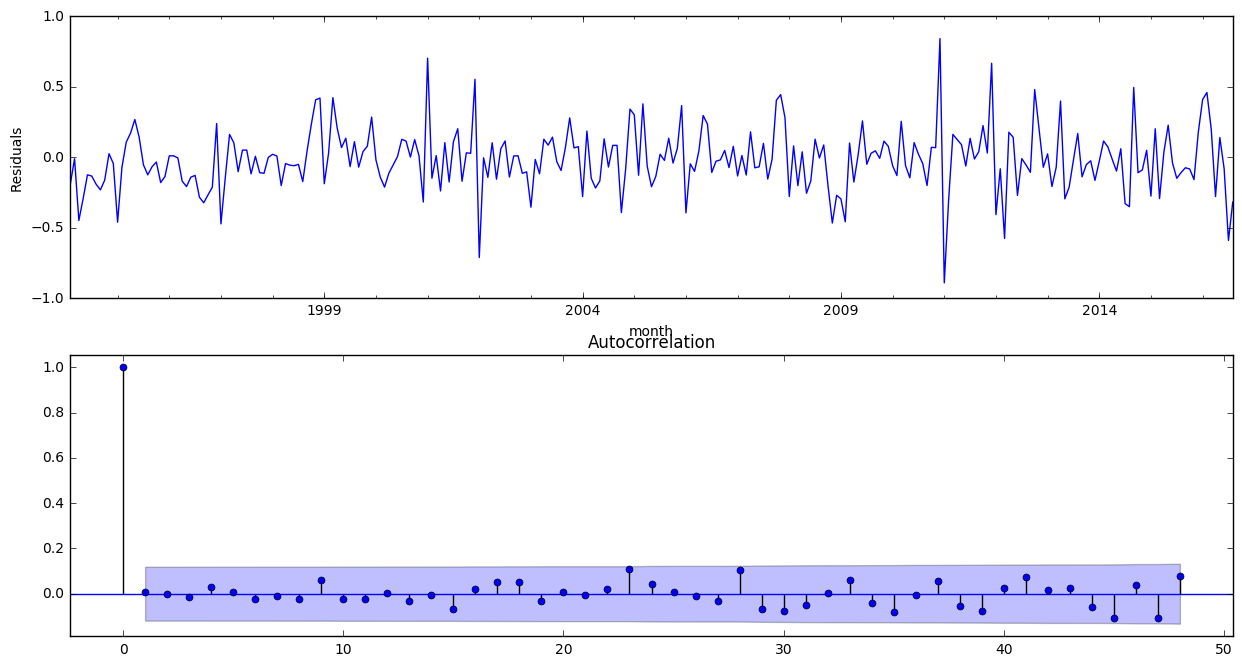

In [18]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

### Анализ остатков
Остатки некоррелированы, несмещены (критерий Стюдента не отвергает гипотезу о $\mathbf{E}(res) = 0$, стационарны

### Прогноз

In [19]:
future = pd.date_range(wages_raw.index[-1], periods=36, freq='M')
forecast = best_model.predict(start=283, end=318)

In [20]:
wages_future = pd.DataFrame(index=forecast.index)
wages_future['future_cox'] = forecast

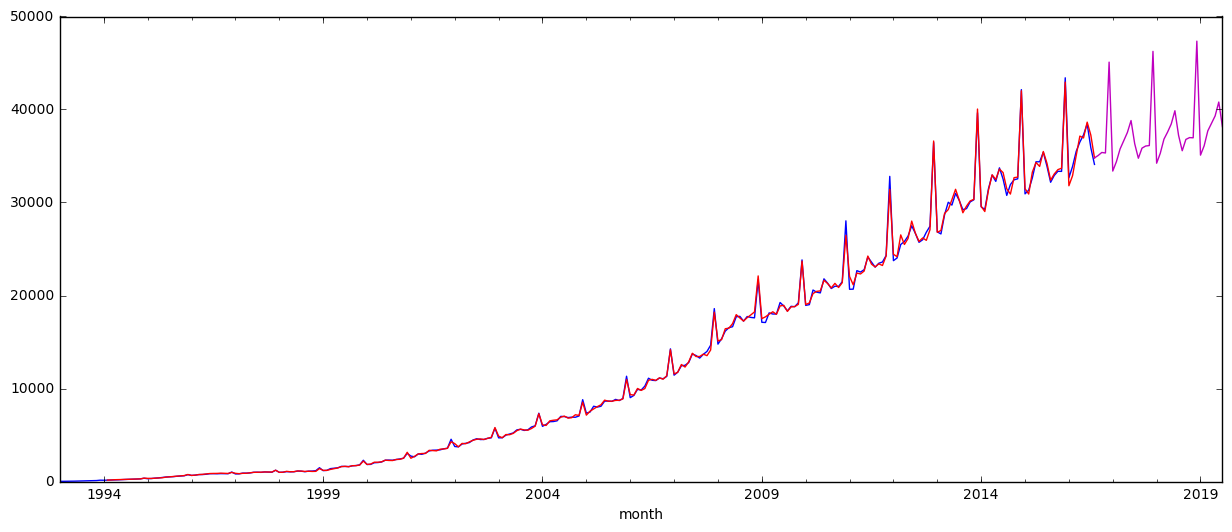

In [21]:
wages_raw['model'] = invboxcox(best_model.fittedvalues, lmbd)
wages_future['future'] = invboxcox(wages_future.future_cox, lmbd)
plt.figure(figsize(15,6))
wages_raw.WAG_C_M.plot()
wages_raw.model[13:].plot(color='r')
wages_future.future.plot(color='m')
plt.show()